# Comparison of best-fit parameters from single-cell microscopy with flow cytometry 

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [87]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The goal of this notebook is to estimate the best-fit parameters for the microscopy fold-change data.

## Data tidying 

The data currently lives as individual csv files in the data directory. For simplicity, we will merge all of these into a single pandas DataFrame. 

In [3]:
# Grab the files with microscopy measured fold-change.
files = glob.glob('../../data/2016*microscopy*foldchange.csv')
all_dfs = []
for i, f in enumerate(files):
    loaded = pd.read_csv(f, comment='#')
    all_dfs.append(loaded)
    
all_data = pd.concat(all_dfs)

For this analysis, we will only look at the operators in which there are at least three replicates. In our case, this is the O1 and O2 operators. 

In [4]:
triplicate_data = all_data[(all_data.operator=='O1') | (all_data.operator=='O2')]

For posterity, we will plot the fold change values for each operator while showing the theoretical predicition based off of the $K_A$ and $K_I$ values from the flow cytometry experiments. 

In [5]:
grouped_data = pd.groupby(triplicate_data, 'operator')

NameError: name 'grouped_data' is not defined

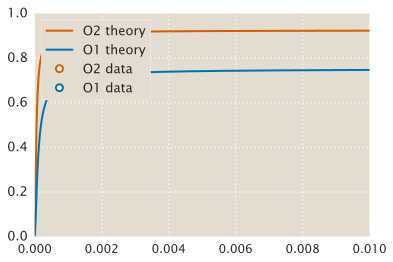

In [15]:
# Define the best-fit values from flow cytometry.
ka_flow = 139E-6  # in units of Molar
ki_flow = 530E-9  # in units of Molar

# Generate the theory curves.
R = np.array([130])
inducer = np.logspace(-9, -2, 1000)
O2_theory = mwc.fold_change_log(inducer, -np.log(ka_flow), -np.log(ki_flow), 4.5, 
                                R, epsilon_r=-13.9)
O1_theory = mwc.fold_change_log(inducer, -np.log(ka_flow), -np.log(ki_flow), 4.5, 
                                R, epsilon_r=-15.3)

# Generate the plot.
plt.figure()
plt.plot(inducer, O2_theory, 'r-', label='O2 theory')
plt.plot(inducer, O1_theory, 'b-', label='O1 theory')
plt.plot([],[], 'o', markerfacecolor='w', markeredgecolor='r', markeredgewidth=2,
         label='O2 data')
plt.plot([],[], 'o', markerfacecolor='w', markeredgecolor='b', markeredgewidth=2,
         label='O1 data')
plt.legend(loc='upper left')


# Plot the data points.
for group, data in grouped_data:
    if group == 'O1':
        plt.plot(data.IPTG_uM/1E6, data.fold_change, 'o', markerfacecolor='w',
                 markeredgewidth=2, markeredgecolor='b')
    if group == 'O2':
        plt.plot(data.IPTG_uM/1E6, data.fold_change, 'o', markerfacecolor='w',
                 markeredgecolor='r', markeredgewidth=2)
   
    
plt.xscale('log')
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
plt.ylim([0, 1.2])    


By eye, they seem to agree rather well with the values estimated from the flow cytometry experiments. It does seem like thre may be a slight rightward systematic shift in the microscopy experiments. We can plot all the data from the flow cytometry experiments for this operator and strain.

In [7]:
# Get the flow data for these operators and strains
flow_files = glob.glob('../../data/*MACS*.csv')
flow_dfs = []
with open('../../data/datasets_ignore.csv') as ig:
    ig_sets = ig.read().splitlines()
    for i, f in enumerate(flow_files):
        if f.lstrip('../../data/') not in ig_sets:
            if ('O2' in f) or ('O1' in f):
                loaded = pd.read_csv(f, comment='#')
                flow_dfs.append(loaded)
flow_data = pd.concat(flow_dfs)

# Drop the other RBS columns.
flow_data = flow_data[(flow_data.rbs == 'RBS1027')]
flow_grouped = pd.groupby(flow_data, 'operator')

(0, 1.2)

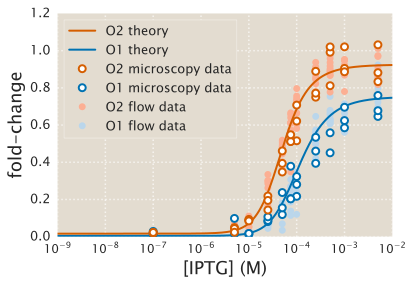

In [8]:
# Define the best-fit values from flow cytometry.
ka_flow = 139E-6  # in units of Molar
ki_flow = 530E-9  # in units of Molar

# Generate the theory curves.
R = np.array([130])
inducer = np.logspace(-9, -2, 1000)
O2_theory = mwc.fold_change_log(inducer, -np.log(ka_flow), -np.log(ki_flow), 4.5, 
                                R, epsilon_r=-13.9)
O1_theory = mwc.fold_change_log(inducer, -np.log(ka_flow), -np.log(ki_flow), 4.5, 
                                R, epsilon_r=-15.3)

# Generate the plot.
O1_color = sns.color_palette('Blues')[1]
O2_color = sns.color_palette('Reds')[1]
plt.figure()
plt.plot(inducer, O2_theory, 'r-', label='O2 theory', zorder=100)
plt.plot(inducer, O1_theory, 'b-', label='O1 theory', zorder=101)
plt.plot([],[], 'o', markerfacecolor='w', markeredgecolor='r', markeredgewidth=2,
         label='O2 microscopy data')
plt.plot([],[], 'o', markerfacecolor='w', markeredgecolor='b', markeredgewidth=2,
         label='O1 microscopy data')
plt.plot([],[], 'o', color = O2_color, label='O2 flow data')
plt.plot([],[], 'o', color = O1_color, label='O1 flow data')
plt.legend(loc='upper left')


# Plot the data points.
for group, data in flow_grouped:
    if group == 'O1':
        plt.plot(data.IPTG_uM/1E6, data.fold_change_A, 'o', color=O1_color,
                zorder=1)
    if group == 'O2':
        plt.plot(data.IPTG_uM/1E6, data.fold_change_A, 'o', color=O2_color,
                zorder=2)

for group, data in grouped_data:
    if group == 'O1':
        plt.plot(data.IPTG_uM/1E6, data.fold_change, 'o', markerfacecolor='w',
                 markeredgewidth=2, markeredgecolor='b', zorder=1000)
    if group == 'O2':
        plt.plot(data.IPTG_uM/1E6, data.fold_change, 'o', markerfacecolor='w',
                 markeredgecolor='r', markeredgewidth=2, zorder=1001)
plt.xscale('log')
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
plt.ylim([0, 1.2])

They certainly appear to be drawn from the same distribution with no painstakingly obvious disagreements. To be precise, we estimate the parameter values for both the flow cytometry and the microscopy data to see how well they agree.  

# Parameter estimation from both experiments. 

See the notebook [`error_propagation.ipynb`](error_propagation.ipynb) for more information on the MCMC analysis. Here, we have used the same functions defined in that experiment. 

In [10]:

def mcmc_pre_process(df):
    """
    Pre-process the tidy DataFrame to prepare it for the MCMC. This is done
    separately from the log-posterior calculation to speed up the process
    avoiding parsing the DataFrame every evaluation of the posterior.
    Parameteres
    -----------
    df : pandas DataFrame.
        A tidy pandas DataFrame as standardized in the project that contains
        at least the following columns:
        fold_change_A : the experimental fold-change from channel A in the
        flow cytometer.
        IPTG_uM : uM concentrations of the inducer
        repressors : the mean repressor copy number
        delta_repressors : the experimental SD on the mean repressor copy number
        binding_energy : the mean repressor binding energy
        delta_energy : the experimental SD on the binding energy


    Returns
    -------
    [rep_unique, eps_unique] : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    """
    # List the unique variables
    rep_unique = np.sort(df.repressors.unique())
    eps_unique = np.sort(df.binding_energy.unique())
    IPTG_unique = np.sort(df.IPTG_uM.unique())
    
    # determine the number of unique variables
    n_repressor = len(rep_unique)
    n_epsilon_r = len(eps_unique)
    n_IPTG = len(IPTG_unique)
    
    # Depending on the number of parameters determine the indexes of the
    # parameters to fit
    param_idx = np.cumsum([3, n_repressor, n_epsilon_r])
    
    # Sort the data frame such that the log-posterior function can
    # automatically compute the log probability with the right parameters
    # for each data point
    df_sort = df.sort(['repressors', 'binding_energy', 'IPTG_uM'])
    data = np.array(df_sort[['fold_change_A', 'IPTG_uM', 
                             'repressors', 'delta_repressors', 
                             'binding_energy', 'delta_energy']])
    return [rep_unique, eps_unique], param_idx, data


def log_likelihood(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log likelihood probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_r = param[param_idx[1]:param_idx[2]] # Represor energies
   
    # Initialize the log_likelihood
    log_like = 0
    # loop through the parameters to fit in order to compute the
    # theoretical fold change using the right parameters for each strain
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 4]==eps), :]
            # compute the theoretical fold-change
            fc_theory = mwc.fold_change_log(data_block[:, 1],
                                            ea, ei, epsilon,
                                            rep[i], eps_r[j])
            # compute the log likelihood for this block of data
            log_like -=  np.sum((fc_theory - data_block[:, 0])**2) / 2 / sigma**2
            
    return log_like

def log_prior(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-prior probability
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log prior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_r = param[param_idx[1]:param_idx[2]] # Represor energies
    
    # Initialize the log_prior
    log_prior = 0
    # loop through the parameters to to fit in order to compute the appropiate
    # log prior
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 4]==eps), :]
            log_prior -= np.sum((rep[i] - data_block[:, 2])**2 / \
                         2 / data_block[:, 3]**2)
            log_prior -= np.sum((eps_r[j] - data_block[:, 4])**2 / \
                         2 / data_block[:, 5]**2)
                
    # check the bounds on the parameterreps
    if np.any(rep <= 0) or (sigma <= 0):
        return -np.inf
    
    return log_prior

def log_post(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    The log posterior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_r = param[param_idx[1]:param_idx[2]] # Represor energies
    
    lnp = log_prior(param, param_idx, unique_var, data, epsilon)
    # Check before computing the likelihood if one of the boundaries set by
    # the prior was not satisfied. If that is the case don't waste time
    # computing the likelihood and return -inf
    if lnp == -np.inf:
        return lnp
    
    return -(len(data) + 1) * np.log(sigma)\
            + log_likelihood(param, param_idx, unique_var, data, epsilon)\
            + lnp

def init_walkers(df, n_walkers, unique_var, param_idx):
    '''
    Initialize walkers according to however many dimensions will be explored
    by the MCMC
    Parameters
    ----------
    df : pandas DataFrame.
        Data frame containing the data that will be used for fitting the
        parameters
    n_walkers : int.
        Number of walkers for the MCMC.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    n_dim : int.
        Number of dimensions that the MCMC walkers will walk on.
    Returns
    -------
    '''
    #Define the parameters for emcee
    n_dim = 3 + np.sum([len(x) for x in unique_var])
    
    # Perform a non-linear regression
    map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
    mean = [map_param[0], map_param[2]]
    cov = np.array([[map_param[1], 0], [0, map_param[3]]])
    
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)# ea, ei
    p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)# sigma
    
    # loop through the repressors
    for i, r in enumerate(unique_var[0]):
        sigma_r = df[df.repressors==r].delta_repressors.unique()
        # Check if any walker was initialized in a forbidden area
        rep_num = np.random.normal(r, sigma_r, n_walkers)
        rep_num[rep_num < 0] = 0
        p0[:, param_idx[0]+i] = rep_num
    for j, eps in enumerate(unique_var[1]):
        sigma_eps = df[df.binding_energy==eps].delta_energy.unique()
        p0[:, param_idx[1]+j] = np.random.normal(eps, sigma_eps, n_walkers)
    
    return p0, n_dim

With these functions defined, we can now begin the sampling. 

In [11]:
# List the error sources as described by Garcia & Phillips PNAS 2011.
delta_R = {'RBS1027':20}
delta_epsilon_r = {'O1':0.2, 'O2':0.2}
# Add the error columns to the data frame
flow_data['delta_repressors'] = pd.Series([delta_R[flow_data.iloc[x].rbs] for x\
                                    in np.arange(flow_data.shape[0])])
flow_data['delta_energy'] = pd.Series([delta_epsilon_r[x] for x in 
                                       flow_data.operator])

We'll first perform the estimation on the flow cytometry data. 

In [12]:
# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(flow_data)

# initialize the walkers
n_walkers = 100
n_burn = 500
n_steps = 5000
p0, n_dim = init_walkers(flow_data, n_walkers, unique_var, param_idx)

#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)


/Users/gchure/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:68: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [13]:
_ = sampler.run_mcmc(pos, n_steps)
output = open('../../data/mcmc/' + str(20161218) + \
              '_error_prop_RBS1027_flow_cytometry.pkl', 'wb')
pickle.dump(sampler.flatchain, output)

In [14]:
# Define the name of the columns for the Data Frame.
columns = np.concatenate([['ka', 'ki', 'sigma'],\
          [flow_data[flow_data.repressors==r].rbs.unique()[0]
               for r in unique_var[0]],
          [flow_data[flow_data.binding_energy==o].operator.unique()[0]
               for o in unique_var[1]]])

# Generarte data frame
mcmc_flow_df = pd.DataFrame(sampler.flatchain, columns=columns)
mcmc_flow_df.insert(np.shape(mcmc_flow_df)[1], 'lnprob', sampler.flatlnprobability)
mcmc_flow_df.head()

,ka,ki,sigma,RBS1027,O1,O2,lnprob
0,-5.041880,0.541118,0.050713,128.765967,-15.320683,-13.888187,631.995297
1,-5.045016,0.538455,0.051191,128.936464,-15.321797,-13.885940,632.548469
2,-5.045016,0.538455,0.051191,128.936464,-15.321797,-13.885940,632.548469
3,-5.045762,0.542316,0.050605,128.828788,-15.321719,-13.884913,631.815201
4,-5.045762,0.542316,0.050605,128.828788,-15.321719,-13.884913,631.815201


In [15]:
mcmc_flow_df['ka']

0        -5.041880
1        -5.045016
2        -5.045016
3        -5.045762
4        -5.045762
5        -5.045762
6        -5.045762
7        -5.022715
8        -5.017766
9        -5.017766
10       -5.017766
11       -5.022183
12       -5.022183
13       -4.998886
14       -5.040784
15       -5.040784
16       -5.022161
17       -5.022161
18       -5.022225
19       -5.047851
20       -5.028582
21       -5.022641
22       -5.022641
23       -5.022641
24       -5.022641
25       -5.026635
26       -5.026635
27       -5.026635
28       -5.026635
29       -5.003915
            ...   
499970   -5.045553
499971   -5.046964
499972   -5.038467
499973   -5.038467
499974   -5.038467
499975   -5.026655
499976   -5.026655
499977   -5.036314
499978   -5.036314
499979   -5.028401
499980   -5.029584
499981   -5.029584
499982   -5.036201
499983   -5.051789
499984   -5.051789
499985   -5.051789
499986   -5.051789
499987   -5.051789
499988   -5.071838
499989   -5.082053
499990   -5.057431
499991   -5.

For completeness, we can generate a plot of the sampled posteriors. 

Now let's proceed with the analysis on the microscopy data. To be compatible with the above functions, we must first rename the `fold_change` column in the microscopy DataFrame.

In [16]:
microscopy_data=triplicate_data.rename(columns = {'fold_change':'fold_change_A'})

In [17]:
# Preprocess the data
microscopy_data['delta_repressors'] = pd.Series([delta_R[microscopy_data.iloc[x].rbs] for x\
                                    in np.arange(microscopy_data.shape[0])])
microscopy_data['delta_energy'] = pd.Series([delta_epsilon_r[x] for x in 
                                       microscopy_data.operator])
unique_var, param_idx, data = mcmc_pre_process(microscopy_data)

# initialize the walkers
n_walkers = 100
n_burn = 500
n_steps = 5000
p0, n_dim = init_walkers(microscopy_data, n_walkers, unique_var, param_idx)

#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)


/Users/gchure/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:68: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [18]:
_ = sampler.run_mcmc(pos, n_steps)
output = open('../../data/mcmc/' + str(20161218) + \
              '_error_prop_RBS1027_microscopy.pkl', 'wb')
pickle.dump(sampler.flatchain, output)

In [19]:
# Define the name of the columns for the Data Frame.
columns = np.concatenate([['ka', 'ki', 'sigma'],\
          [microscopy_data[microscopy_data.repressors==r].rbs.unique()[0]
               for r in unique_var[0]],
          [microscopy_data[microscopy_data.binding_energy==o].operator.unique()[0]
               for o in unique_var[1]]])

# Generarte data frame
mcmc_microscopy_df = pd.DataFrame(sampler.flatchain, columns=columns)
mcmc_microscopy_df.insert(np.shape(mcmc_microscopy_df)[1], 'lnprob', sampler.flatlnprobability)
mcmc_microscopy_df.head()


,ka,ki,sigma,RBS1027,O1,O2,lnprob
0,-4.842972,0.570860,0.089067,129.167699,-15.275574,-13.964781,140.883599
1,-4.864376,0.559059,0.088756,129.355458,-15.279341,-13.963055,141.230981
2,-4.864376,0.559059,0.088756,129.355458,-15.279341,-13.963055,141.230981
3,-4.864376,0.559059,0.088756,129.355458,-15.279341,-13.963055,141.230981
4,-4.868444,0.556286,0.088213,129.357646,-15.281906,-13.958848,141.620665


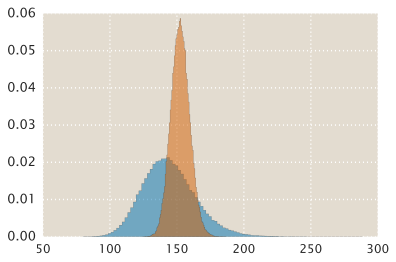

In [20]:
plt.figure()
_ = plt.hist(np.exp(-mcmc_microscopy_df['ka']), bins=100, histtype='stepfilled', color='b', alpha=0.5, normed=True)
_ = plt.hist(np.exp(-mcmc_flow_df['ka']), bins=100, histtype='stepfilled', color='r', alpha=0.5, normed=True)

In [21]:
# Draw the corner plot
#fig = corner.corner(sampler.flatchain, bins=50, plot_contours=False,
#                     rasterized=True)

## Performing the comparison 

Let's look at these values and compare them with each other. 

In [22]:
# Generate data frame to keep the parameters
flow_param_fit = pd.DataFrame(mcmc_flow_df.loc[np.argmax(mcmc_flow_df.lnprob)][:-1])
microscopy_param_fit = pd.DataFrame(mcmc_microscopy_df.loc[np.argmax(mcmc_microscopy_df.lnprob)][:-1])
flow_param_fit.columns = ['mode']
microscopy_param_fit.columns = ['mode']

# Generate parameter to save the hpd for each parameter
flow_param_hpd = pd.DataFrame(columns=['hpd_max', 'hpd_min'])
microscopy_param_hpd = pd.DataFrame(columns=['hpd_max', 'hpd_min'])

# Loop through each parameter computing the 95% hpd
for column in mcmc_flow_df:
    flow_param_hpd = flow_param_hpd.append(pd.Series(mwc.hpd(mcmc_flow_df[column], 0.95), 
                               index=['hpd_max', 'hpd_min'], name=column))    
for column in mcmc_microscopy_df:
    microscopy_param_hpd = microscopy_param_hpd.append(pd.Series(mwc.hpd(mcmc_microscopy_df[column], 0.95), 
                               index=['hpd_max', 'hpd_min'], name=column))
    
# Combine the data frames into a single data frame
flow_param_fit = pd.concat([flow_param_fit, flow_param_hpd], axis=1)
flow_param_fit.columns = ['mode','hpd_max', 'hpd_min']
flow_param_fit.insert(0, 'method', 'flow')
microscopy_param_fit = pd.concat([microscopy_param_fit, microscopy_param_hpd], axis=1)
microscopy_param_fit.columns = ['mode','hpd_max', 'hpd_min']
microscopy_param_fit.insert(0, 'method', 'microscopy')
param_fit = pd.concat([microscopy_param_fit, flow_param_fit])
param_fit.to_csv('../../data/mcmc/microscopy_flow_fit_values.csv', index=False)

In [23]:
param_fit

,method,mode,hpd_max,hpd_min
O1,microscopy,-15.303371,-15.370269,-15.241285
O2,microscopy,-13.893816,-13.958450,-13.830635
RBS1027,microscopy,129.698958,125.442165,134.635239
ka,microscopy,-4.947993,-5.225325,-4.694638
ki,microscopy,0.488855,0.317193,0.650989
lnprob,microscopy,NaN,137.874609,144.093578
sigma,microscopy,0.081266,0.070661,0.098921
O1,flow,-15.316828,-15.351277,-15.286034
O2,flow,-13.881006,-13.912179,-13.846375
RBS1027,flow,129.838430,127.528027,132.421852


In [24]:
# Report the mean and hpd.
labels = []
vals = ['ka', 'ki']
modes = ['flow', 'microscopy']
for v in vals:
    flow = np.exp(-flow_param_fit['mode'][v])
    flow_max = np.exp(-flow_param_fit['hpd_max'][v])
    flow_min = np.exp(-flow_param_fit['hpd_min'][v])  
    labels.append(flow) 
    labels.append(flow_max - flow)
    labels.append(flow - flow_min)
    mic = np.exp(-microscopy_param_fit['mode'][v])
    mic_max = np.exp(-microscopy_param_fit['hpd_max'][v])
    mic_min = np.exp(-microscopy_param_fit['hpd_min'][v]) 
    labels.append(mic) 
    labels.append(mic_max - mic)
    labels.append(mic - mic_min)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka_flow = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ka_microscopy = {3:.2f} +{4:0.3f} -{5:0.3f} uM
Ki_flow = {6:.5f} +{7:0.6f} -{8:0.6f} uM
Ki_microscopy = {9:.5f} +{10:0.6f} -{11:0.6f} uM
""".format(*tuple(labels))) 


The most probable parameters for the MWC model
----------------------------------------------
Ka_flow = 152.14 +14.918 -12.764 uM
Ka_microscopy = 140.89 +45.030 -31.533 uM
Ki_flow = 0.57993 +0.031811 -0.031227 uM
Ki_microscopy = 0.61333 +0.114862 -0.091798 uM



# Plotting the fit parameters

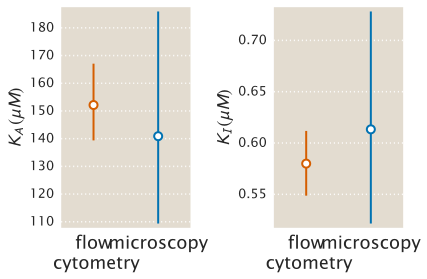

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].vlines(1, labels[0] - labels[2], labels[1] + labels[0], color='r', linewidth=2)
ax[0].vlines(2, labels[3] - labels[5], labels[4] + labels[3], color='b', linewidth=2)
ax[1].vlines(1, labels[6] - labels[8], labels[6] + labels[7], color='r', linewidth=2)
ax[1].vlines(2, labels[9] - labels[11], labels[9] + labels[10], color='b', linewidth=2)
ax[0].plot(1, labels[0], 'o', markerfacecolor='w', markeredgewidth=2,
           markeredgecolor='r', markersize=8)
ax[0].plot(2, labels[3], 'o', markerfacecolor='w', markeredgewidth=2,
           markeredgecolor='b', markersize=8)
ax[1].plot(1, labels[6], 'o', markerfacecolor='w', markeredgewidth=2,
           markeredgecolor='r', markersize=8)
ax[1].plot(2, labels[9], 'o', markerfacecolor='w', markeredgewidth=2,
           markeredgecolor='b', markersize=8)
ax[0].margins(0.02)
ax[1].margins(0.02)
ax[0].set_xlim([.5, 2.5])
ax[1].set_xlim([.5, 2.5])
ax[0].xaxis.set_ticks([1, 2])
ax[0].xaxis.set_ticklabels(['flow\n cytometry', 'microscopy'], fontsize=18)
ax[1].xaxis.set_ticks([1, 2])
ax[1].xaxis.set_ticklabels(['flow\n cytometry', 'microscopy'], fontsize=18)
ax[0].set_ylabel(r'$K_A\, (\mu M)$', fontsize=18)
ax[1].set_ylabel(r'$K_I\, (\mu M)$', fontsize=18)
ax[0].xaxis.grid(False)
ax[1].xaxis.grid(False)
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/supplementary_figures/flow_microscopy_kaki_comparison.pdf',
           bbox_inches='tight', dpi=200)

##  Global fit of $K_A$ and $K_I$

In [2]:
def log_likelihood(param, indep_var, dep_var, epsilon=4.5):
    """
    Computes the log likelihood probability.
    Parameters
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # unpack parameters
    ea, ei, sigma = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r)
   
    log_like =  np.sum((fc_theory - dep_var)**2) / 2 / sigma**2
    return log_like
   
def log_post(param, indep_var, dep_var, epsilon=4.5,
             ea_range=[6, -6], ei_range=[6, -6], sigma_range=[0, 1]):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    '''
    # unpack parameters
    ea, ei, sigma = param
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ea < np.min(ei_range)\
    or sigma > np.max(sigma_range) or sigma < np.min(sigma_range):
        return -np.inf
    
    return -(len(indep_var) + 1) * np.log(sigma) \
    - log_likelihood(param, indep_var, dep_var, epsilon)

In [17]:
# Load the flow and restrict the data sets.
flow_df = pd.read_csv('../../data/flow_master.csv', comment='#')
flow_df = flow_df[(flow_df.rbs=='RBS1027')
                  & ((flow_df.operator=='O1') | (flow_df.operator=='O2'))]
flow_indep = flow_df[['IPTG_uM', 'repressors', 'binding_energy']]
flow_dep = flow_df.fold_change_A

# Load in the microscopy set and restrict.
mic_df = pd.read_csv('../../data/microscopy_master.csv', comment='#')
mic_df = mic_df.rename(columns={'fold_change' : 'fold_change_A'})
mic_df = mic_df[(mic_df.rbs == 'RBS1027') &
               ((mic_df.operator=='O1') | (mic_df.operator=='O2'))]
mic_indep = mic_df[['IPTG_uM', 'repressors', 'binding_energy']]
mic_dep = mic_df.fold_change_A

# Set up the MCMC parameters.
n_dim = 3 # number of parameters to fit
n_walkers = 50
n_burn = 500
n_steps = 5000

In [18]:
# Find starting positions
flow_map_param =  mwc.non_lin_reg_mwc(flow_df, p0=[1, 7], diss_const=False)
flow_mean = [flow_map_param[0], flow_map_param[2]]
flow_cov = np.array([[flow_map_param[1], 0], [0, flow_map_param[3]]])
mic_map_param =  mwc.non_lin_reg_mwc(mic_df, p0=[1, 7], diss_const=False)
mic_mean = [mic_map_param[0], mic_map_param[2]]
mic_cov = np.array([[mic_map_param[1], 0], [0, mic_map_param[3]]])



# Initialize the walkers.
flow_p0 = np.empty((n_walkers, n_dim))
flow_p0[:,[0, 1]] = np.random.multivariate_normal(flow_mean, flow_cov, n_walkers)
flow_p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)
mic_p0 = np.empty((n_walkers, n_dim))
mic_p0[:,[0, 1]] = np.random.multivariate_normal(mic_mean, mic_cov, n_walkers)
mic_p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

# Set the ranges for the MCMC
ea_range = [-7, 7]
ei_range = [-7, 7]
sigma_range = [0, flow_df.groupby('rbs').fold_change_A.std().max()]
# Call the sampler.
print('Beginning flow MCMC')
flow_sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,
                                args=(flow_indep, flow_dep, 4.5, ea_range,
                                      ei_range, sigma_range), threads=6)
print('Beginning microscopy MCMC')
mic_sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,
                                args=(mic_indep, mic_dep, 4.5, ea_range,
                                      ei_range, sigma_range), threads=6)

Beginning flow MCMC
Beginning microscopy MCMC


In [19]:
sample = True 
if sample:
    # Do the burn in
    flow_pos, flow_prob, flow_state = flow_sampler.run_mcmc(flow_p0,
                n_burn, storechain=False)
    mic_pos, mic_prob, mic_state = mic_sampler.run_mcmc(mic_p0,
                n_burn, storechain=False)
    # Perform the real MCMC
    f_ = flow_sampler.run_mcmc(flow_pos, n_steps)
    m_ = mic_sampler.run_mcmc(mic_pos, n_steps)
    with open('../../data/mcmc/SI_C_all_data_O1O2_KaKi_flow_cytometry.pkl', 'wb') as output:
        pickle.dump(flow_sampler.flatchain, output)
        pickle.dump(flow_sampler.flatlnprobability, output) 

    with open('../../data/mcmc/SI_C_all_data_O1O2_KaKi_microscopy.pkl', 'wb') as output:
        pickle.dump(mic_sampler.flatchain, output)
        pickle.dump(mic_sampler.flatlnprobability, output) 

In [29]:
# Load the chains.
# read the flat-chain
with open('../../data/mcmc/SI_C_all_data_O1O2_KaKi_flow_cytometry.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    flow_gauss_flatchain = unpickler.load()
    flow_gauss_flatlnprobability = unpickler.load()

with open('../../data/mcmc/SI_C_all_data_O1O2_KaKi_microscopy.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    mic_gauss_flatchain = unpickler.load()
    mic_gauss_flatlnprobability = unpickler.load()


# Generate a Pandas Data Frame with the mcmc chain
index = ['ka', 'ki', 'sigma']

# Generate a data frame out of the MCMC chains
flow_mcmc = pd.DataFrame(flow_gauss_flatchain, columns=index)
mic_mcmc = pd.DataFrame(mic_gauss_flatchain, columns=index)

flow_mcmc['Ka'] = np.exp(-flow_mcmc['ka'])
flow_mcmc['Ki'] = np.exp(-flow_mcmc['ki'])
mic_mcmc['Ka'] = np.exp(-mic_mcmc['ka'])
mic_mcmc['Ki'] = np.exp(-mic_mcmc['ki'])

index = flow_mcmc.columns
index = mic_mcmc.columns

# map value of the parameters
flow_max_idx = np.argmax(flow_gauss_flatlnprobability, axis=0)
mic_max_idx = np.argmax(mic_gauss_flatlnprobability, axis=0)
f_ea, f_ei, f_sigma, f_ka, f_ki = flow_mcmc.ix[flow_max_idx, :]
m_ea, m_ei, m_sigma, m_ka, m_ki = mic_mcmc.ix[mic_max_idx, :]
f_ka = f_ka / 1E6
f_ki = f_ki / 1E6
m_ka = m_ka / 1E6
m_ki = m_ki / 1E6
# ea range
flow_ka_hpd = mwc.hpd(flow_mcmc.ix[:, 3], 0.95)
flow_ki_hpd = mwc.hpd(flow_mcmc.ix[:, 4], 0.95)
mic_ka_hpd = mwc.hpd(mic_mcmc.ix[:, 3], 0.95)
mic_ki_hpd = mwc.hpd(mic_mcmc.ix[:, 4], 0.95)

In [103]:
print(f_ka * 1E6, m_ka * 1E6)
print(f_ki* 1E6, m_ki*1E6)
print(flow_ka_hpd, mic_ka_hpd)
print(flow_ki_hpd, mic_ki_hpd)

149.057998634 141.799731739
0.573766817433 0.615260676602
[ 136.57179495  163.20996384] [ 107.75826672  182.88738925]
[ 0.54544372  0.60461453] [ 0.5221363   0.72269372]


##  Plotting flow and microscopy data with fit parameters

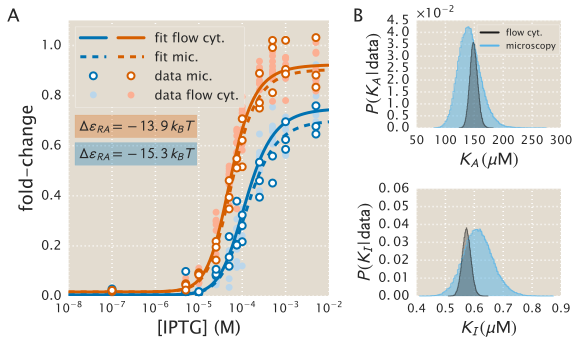

In [101]:
# Group the data together.
flow_grouped = pd.groupby(flow_df, 'operator')
mic_grouped = pd.groupby(mic_df, 'operator')


fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot2grid((4,5), (0,0), colspan=3, rowspan=4)
ax2 = plt.subplot2grid((4,5), (2,3), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4,5), (0,3), rowspan=2, colspan=2)


# Plot the flow and microscopy data.
inducer = np.logspace(-8, -2, 500)
flow_O2_theory = mwc.fold_change_log(inducer, -np.log(f_ka), -np.log(f_ki), 4.5, 
                                R, epsilon_r=-13.9)
flow_O1_theory = mwc.fold_change_log(inducer, -np.log(f_ka), -np.log(f_ki), 4.5, 
                                R, epsilon_r=-15.3)
mic_O2_theory = mwc.fold_change_log(inducer, -np.log(m_ka), -np.log(m_ki), 4.5, 
                                R, epsilon_r=-13.9)
mic_O1_theory = mwc.fold_change_log(inducer, -np.log(m_ka), -np.log(m_ki), 4.5, 
                                R, epsilon_r=-15.3)
O1_color = sns.color_palette('Blues')[1]
O2_color = sns.color_palette('Reds')[1]

ax1.plot(inducer, flow_O1_theory, 'b-', lw=3, zorder=101)
ax1.plot(inducer, mic_O1_theory, 'b--', lw=3, zorder=101)
ax1.plot([],[], 'o', markerfacecolor='w', markeredgecolor='b', markeredgewidth=2,
         )
ax1.plot([],[], 'o', color = O1_color,)

ax1.plot(inducer, flow_O2_theory, 'r-', lw=3, zorder=100)
ax1.plot(inducer, mic_O2_theory, 'r--', lw=3, zorder=100)
ax1.plot([],[], 'o', markerfacecolor='w', markeredgecolor='r', markeredgewidth=2,
         )
ax1.plot([],[], 'o', color = O2_color)
labs = ['', '', '', '', 'fit flow cyt.', 'fit mic.', 'data mic.', 'data flow cyt.']
ax1.legend(labs, loc='upper left', ncol=2, columnspacing=0.1,fontsize=13)
t1 = ax1.text(0.04, 0.5, r'$\Delta\varepsilon_{RA} = -15.3\,k_BT$',
          fontsize=15, transform=ax1.transAxes)
t1.set_bbox(dict(color='b', alpha=0.3))
t2 = ax1.text(0.04, 0.6, r'$\Delta\varepsilon_{RA} = -13.9\,k_BT$',
          fontsize=15, transform=ax1.transAxes)
t2.set_bbox(dict(color='r', alpha=0.3))

# Plot the data points.
for group, data in flow_grouped:
    if group == 'O1':
        ax1.plot(data.IPTG_uM/1E6, data.fold_change_A, 'o', color=O1_color,
                zorder=1)
    if group == 'O2':
        ax1.plot(data.IPTG_uM/1E6, data.fold_change_A, 'o', color=O2_color,
                zorder=2)

for group, data in mic_grouped:
    if group == 'O1':
        ax1.plot(data.IPTG_uM/1E6, data.fold_change_A, 'o', markerfacecolor='w',
                 markeredgewidth=2, markeredgecolor='b', zorder=1000)
    if group == 'O2':
        ax1.plot(data.IPTG_uM/1E6, data.fold_change_A, 'o', markerfacecolor='w',
                 markeredgecolor='r', markeredgewidth=2, zorder=1001)
        
ax1.set_xscale('log')
ax1.set_xlabel('[IPTG] (M)')
ax1.set_ylabel('fold-change')
ax1.set_ylim([0, 1.1])

ax3.plot([], [], linestyle='-', color='k',
        label='flow cyt.', markersize=5)
ax3.plot([], [], linestyle='-', color='c',
         label='microscopy', markersize=5)

#Add the legend
ax3.legend(bbox_to_anchor=(1.02, 1.0), fontsize=9)

f_ka_hist, f_ka_bins = np.histogram(flow_mcmc['Ka'],  bins=100)
f_ka_hist = f_ka_hist / np.sum(f_ka_hist)
f_ki_hist, f_ki_bins = np.histogram(flow_mcmc['Ki'],  bins=100)
f_ki_hist = f_ki_hist / np.sum(f_ki_hist)
m_ka_hist, m_ka_bins = np.histogram(mic_mcmc['Ka'],  bins=100)
m_ka_hist = m_ka_hist / np.sum(m_ka_hist)
m_ki_hist, m_ki_bins = np.histogram(mic_mcmc['Ki'],  bins=100)
m_ki_hist = m_ki_hist / np.sum(m_ki_hist)
ax3.step(m_ka_bins[:-1], m_ka_hist, color='c', alpha=0.7, lw=1)
ax3.fill_between(m_ka_bins[:-1], m_ka_hist, color='c', alpha=0.5)
ax3.step(f_ka_bins[:-1], f_ka_hist, color='k', alpha=0.5, lw=1)
ax3.fill_between(f_ka_bins[:-1], f_ka_hist, color='k', alpha=0.3)
ax2.step(m_ki_bins[:-1], m_ki_hist, color='c', alpha=0.7, lw=1)
ax2.fill_between(m_ki_bins[:-1], m_ki_hist, color='c', alpha=0.5)
ax2.step(f_ki_bins[:-1], f_ki_hist, color='k', alpha=0.5, lw=1)
ax2.fill_between(f_ki_bins[:-1], f_ki_hist, color='k', alpha=0.3)

#ax2.hist(, bins=100, color='m', 
#         normed=True, alpha=0.45, histtype='stepfilled')
#ax3.hist(, bins=100, color='g',
#          normed=True, alpha=0.45, histtype='stepfilled')
#ax3.hist(, bins=100, color='m',
#         normed=True, alpha=0.45, histtype='stepfilled')
# Plot the parameters from the main text as a horizontal line.
fig.text(0, 0.92, 'A', fontsize=18)
fig.text(0.6, 0.92, 'B', fontsize=18)
ax3.set_ylabel(r'$P\,(K_A\, |\, \mathrm{data})$')
ax2.set_ylabel(r'$P\,(K_I\, |\, \mathrm{data})$')
ax2.set_ylim([0, 0.06])
ax3.set_xlabel('$K_A\, (\mu \mathrm{M})$')
ax2.set_xlabel('$K_I\, (\mu \mathrm{M})$')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(-1,0))
ax3.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
ax3.ticklabel_format(style='sci', axis='y', scilimits=(-1,0))
ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
#
## Save it.
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/supplementary_figures/microscopy_flow_comparison.pdf',
           bbox_inches='tight', dpi=300)

In [61]:
print(len(f_ki_bins), len(f_k))

101 100


In [63]:
ax2.plot?